# Histogramm: Radar -Lidar

## Imports

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from RadarLidarWindSpeed import RadarLidarWindSpeed

In [3]:
dateBegin = datetime(2020, 7, 1)
dateEnd = datetime(2020, 7, 31)
analysis = RadarLidarWindSpeed(dateBegin, dateEnd)
analysis.importDataset()
analysis.calculateDifferences()

In [14]:
minHeight = 0
maxHeight = 15000
diffs = analysis.dataframe['speedDifference'].tolist()
diffs = [x for x in diffs if str(x) != 'nan']
array = np.array(diffs)
np.clip(array,-20,20,out=array)
mu = array.mean()
median = np.median(array)
sigma = np.std(array)

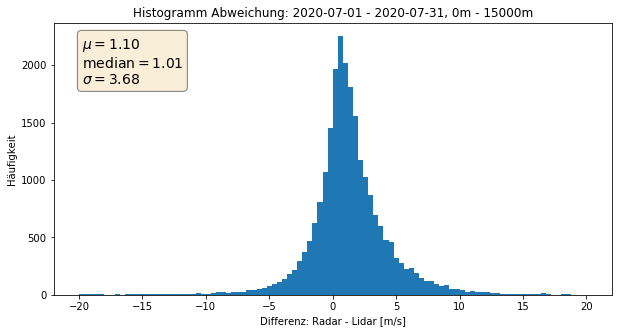

In [15]:
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (sigma, )))
fig, ax = plt.subplots(figsize=(10, 5))

plt.title("Histogramm Abweichung: "+dateBegin.strftime("%Y-%m-%d")+" - "+dateEnd.strftime("%Y-%m-%d")+", "+str(minHeight)+"m - "+str(maxHeight)+"m")
plt.xlabel("Differenz: Radar - Lidar [m/s]")
plt.ylabel("Häufigkeit")
ax.hist(diffs, range=[-20,20],bins=100)

# place a text box in upper left in axes coords
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)

plt.savefig('histogramm_'+str(minHeight)+'_'+str(maxHeight)+'.png')
plt.show()